# Data Preparation

In [1]:
%%time

import numpy as np

images = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}")
print(f"masks:{masks.shape}")
print(f"labels:{labels.shape}")

images:(3064,)
masks:(3064,)
labels:(3064,)
CPU times: user 1.47 s, sys: 3.2 s, total: 4.67 s
Wall time: 21.4 s


**Stacking rows as a data frame.**

In [2]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

# Visualization of data

* **Class Distribution**

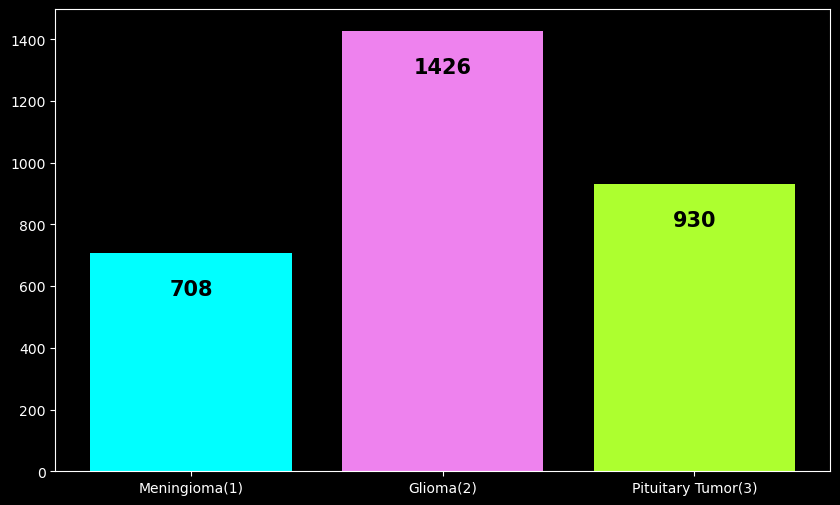

In [3]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

labels, counts = np.unique(data[:,2], return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(labels, counts, color=["aqua", "violet", "greenyellow"],
        tick_label=['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'])

# Annotate
for row, value in zip(labels,counts):
    plt.annotate(int(value), xy=(row, value-150), 
                rotation=0, color="black", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

* **Samples of images of each class**

In [4]:
import cv2

def data_to_viz(data, label, n=5):
    
    # logical slice for receiving data with the expected label
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]
    
    # n random samples
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]
    
    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:
        
        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"), 
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

* **Detailed Data**

In [5]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


* **Plotting**

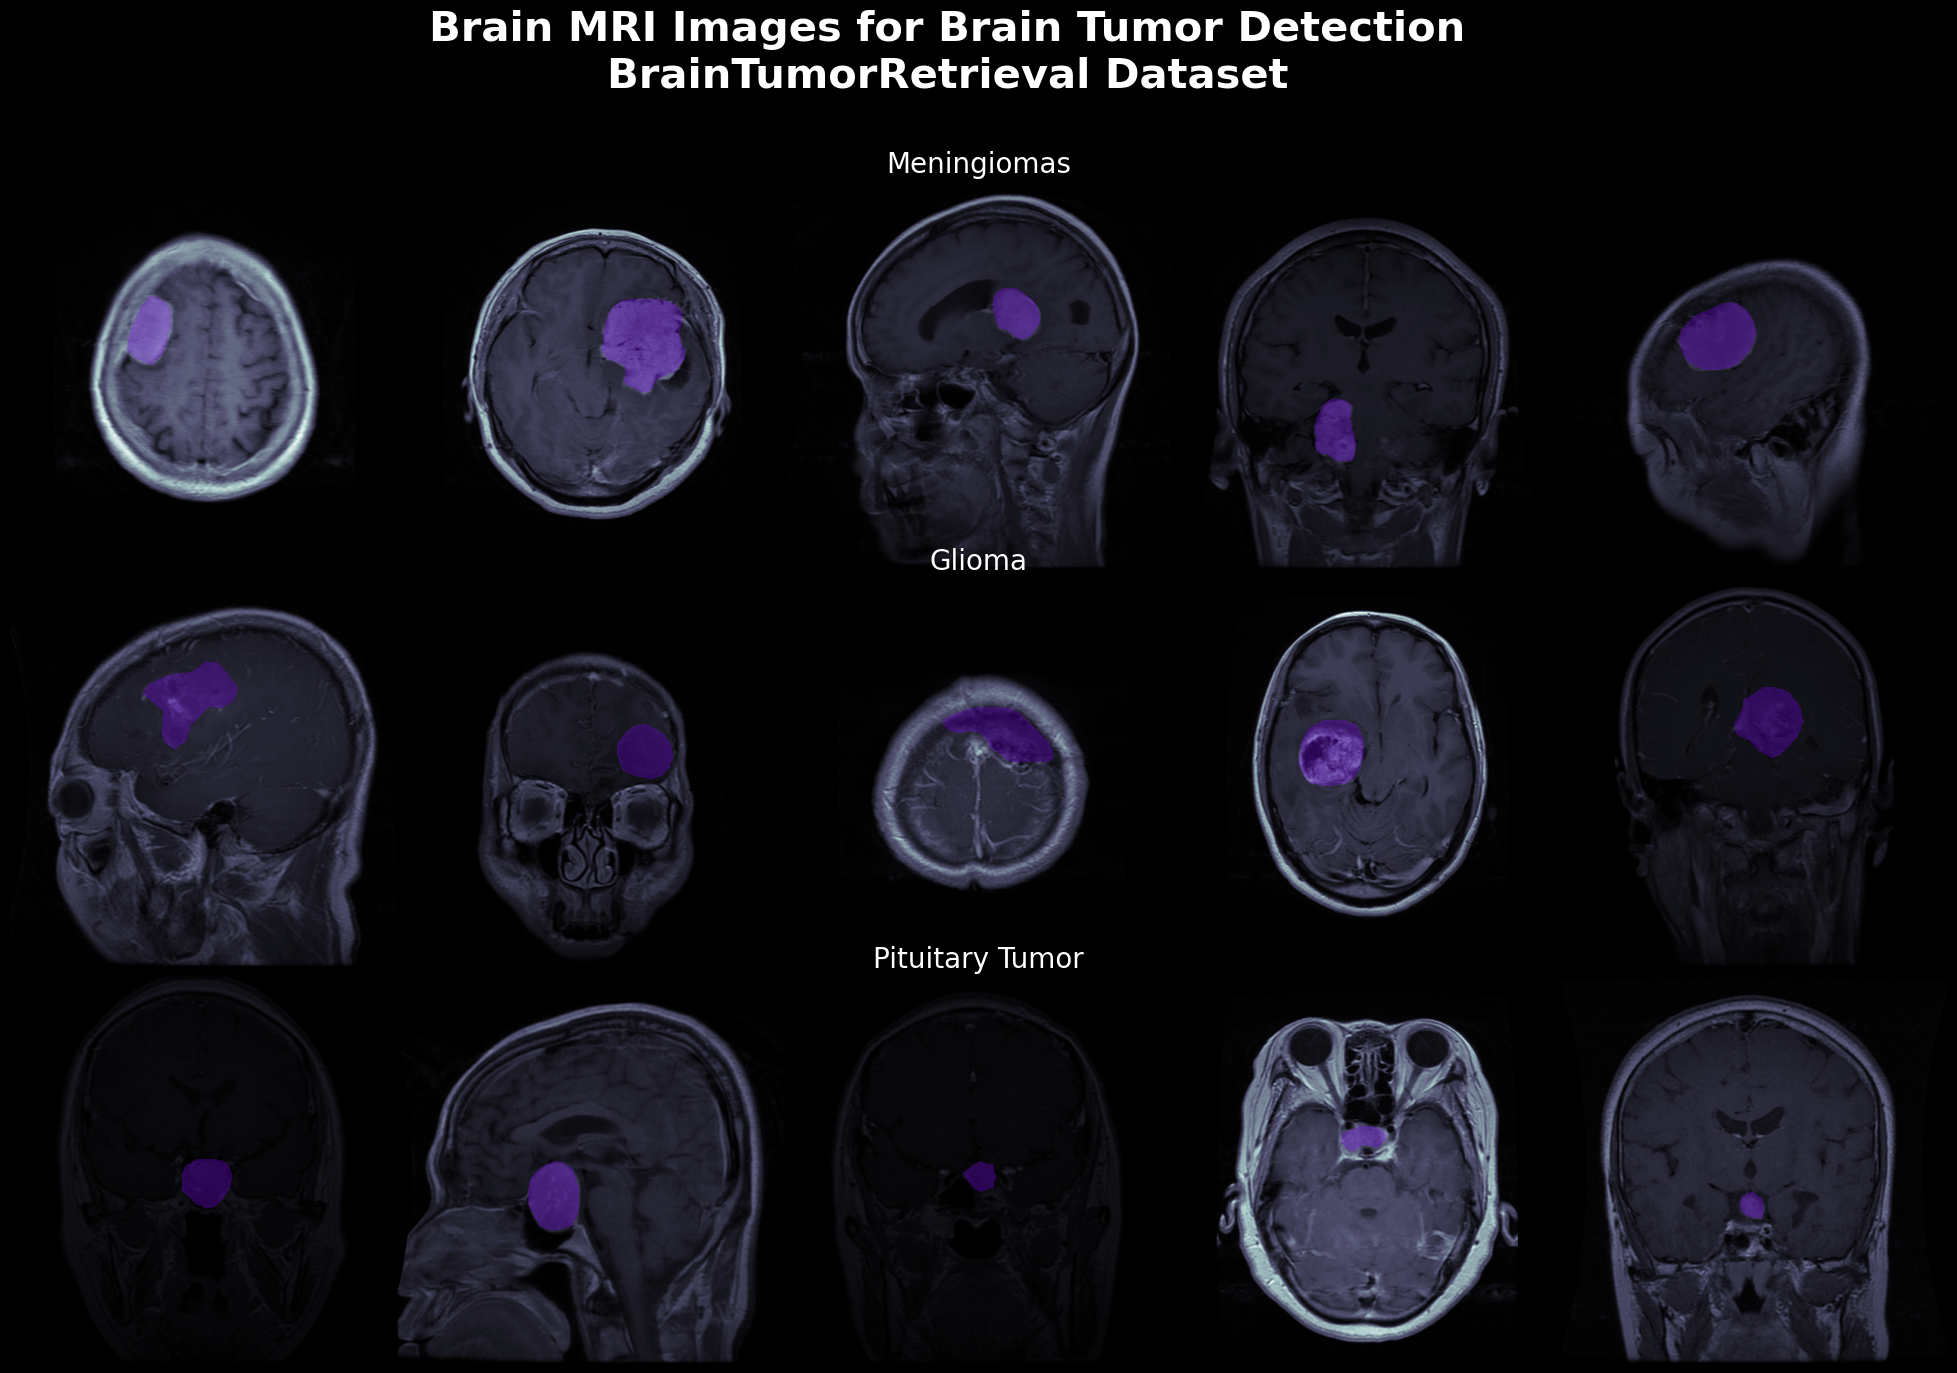

In [6]:
# Data to visualization
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False, 
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()

* **Gray level histogram**

In [7]:
def gray_hist(image, bins=51):
    plt.hist(image.reshape((-1,)), bins)
    plt.show()

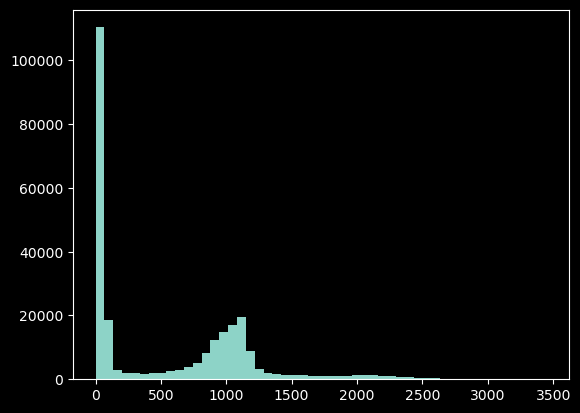

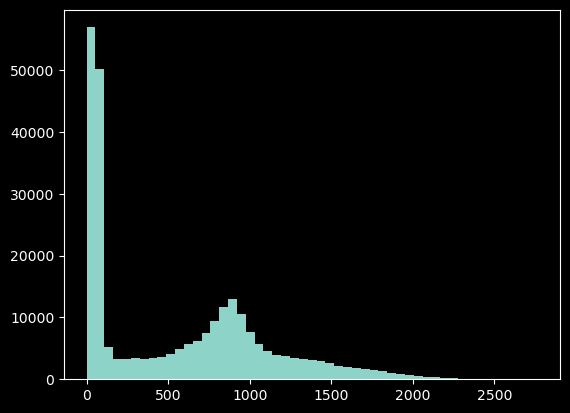

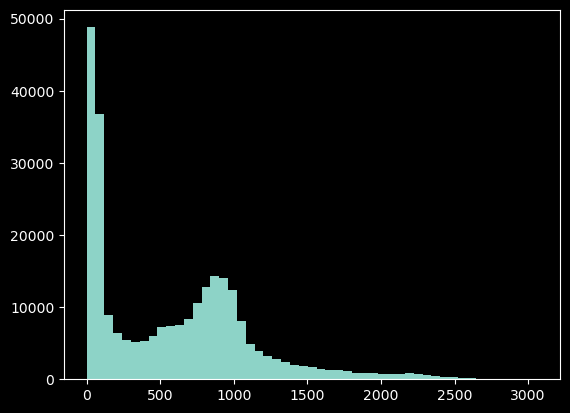

In [8]:
import random
for i in range(3):
    idx = random.randint(0, 3065)
    image = cv2.resize(data[idx][0], (512, 512))
    gray_hist(image)

# Data Splitting 

In [9]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

print("Train:", train_data.shape, "\nVal:", val_data.shape)

Train: (2451, 3) 
Val: (613, 3)


# Data Preprocessing

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import medfilt

import albumentations as A
#from albumentations.pytorch import ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
import os
os.mkdir('/kaggle/working/brain-tumor')
os.mkdir('/kaggle/working/brain-tumor/processed-images')
os.mkdir('/kaggle/working/brain-tumor/processed-images/train')
os.mkdir('/kaggle/working/brain-tumor/processed-images/train/1')
os.mkdir('/kaggle/working/brain-tumor/processed-images/train/2')
os.mkdir('/kaggle/working/brain-tumor/processed-images/train/3')
os.mkdir('/kaggle/working/brain-tumor/processed-images/val')
os.mkdir('/kaggle/working/brain-tumor/processed-images/val/1')
os.mkdir('/kaggle/working/brain-tumor/processed-images/val/2')
os.mkdir('/kaggle/working/brain-tumor/processed-images/val/3')

for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor'):
    print(os.path.join(dirname))

/kaggle/working/brain-tumor
/kaggle/working/brain-tumor/processed-images
/kaggle/working/brain-tumor/processed-images/val
/kaggle/working/brain-tumor/processed-images/val/3
/kaggle/working/brain-tumor/processed-images/val/1
/kaggle/working/brain-tumor/processed-images/val/2
/kaggle/working/brain-tumor/processed-images/train
/kaggle/working/brain-tumor/processed-images/train/3
/kaggle/working/brain-tumor/processed-images/train/1
/kaggle/working/brain-tumor/processed-images/train/2


In [12]:
for dirname,_, filenames in os.walk('/kaggle/working/brain-tumor/processed-images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        os.remove(path)

In [13]:
import cv2
from matplotlib.colors import Normalize
import random

class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):
        
        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")

        norm = Normalize(vmin= image.min(), vmax = image.max())
        image = norm(image)
        
        image = np.stack([image]*3).transpose(1,2,0)
    
        label = self.data[idx][2]
        
        # augmentations
        
        augmented = self.transforms(image=image)
        image = augmented['image']
        
        image = medfilt(image, kernel_size = 3)

        return image, label

* **Data Transformation**

In [14]:
import random
transforms = A.Compose([
        
        A.HorizontalFlip(p= 0.3),
        A.ShiftScaleRotate(scale_limit=0.0, rotate_limit= 20, shift_limit=0.1, p= 0.7,border_mode=0),
        A.RandomScale(scale_limit=0.1, p=0.8),
        A.RandomRotate90(p = 0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2,min_height=2, 
                        min_width=2, fill_value=0, p=1.0),
        A.Resize(224, 224, p=1.),
        
        ])

# **Writing Preprocessed images to disk**

In [15]:
j  = 1
train_dataset=None
val_dataset = None

for i in range(4):
    print(i)
    train_dataset = BrainMriDataset(data=train_data , transforms=transforms)
    print(len(train_dataset))
    for item in train_dataset:
        img, label = item
        plt.imsave('/kaggle/working/brain-tumor/processed-images/train/{}/{}.jpg'.format(label, j), img)
        j+=1
print('Train Write Completed.\nstarting Validation writing...')
for i in range(4):
    print(i)
    val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
    print(len(val_dataset))
    for item in val_dataset:
        img, label = item
        plt.imsave('/kaggle/working/brain-tumor/processed-images/val/{}/{}.jpg'.format(label, j), img)
        j+=1

print('Validation Write Completed.')


0
2451
1
2451
2
2451
3
2451
Train Write Completed.
starting Validation writing...
0
613
1
613
2
613
3
613
Validation Write Completed.


In [18]:
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/train/3'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Train, Pitutary", count)

count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/train/2'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Train, Glioma",count)

count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/train/1'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Train, Meningioma",count)

count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/val/3'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Val, Pitutary", count)

count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/val/2'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Val, Glioma",count)

count = 0
for dirname, _, filenames in os.walk('/kaggle/working/brain-tumor/processed-images/val/1'):
    for filename in filenames:
        count+=1
#         print(os.path.join(dirname, filename))
print("Val, Meningioma",count)

Train, Pitutary 3028
Train, Glioma 4580
Train, Meningioma 2196
Val, Pitutary 692
Val, Glioma 1124
Val, Meningioma 636


# Image Testing

In [19]:
print(val_dataset[4][0].shape)
print(train_dataset[3][0].shape)


(224, 224, 3)
(224, 224, 3)


In [20]:
classes = ["Meningioma","Glioma" ,"Pitutary"]

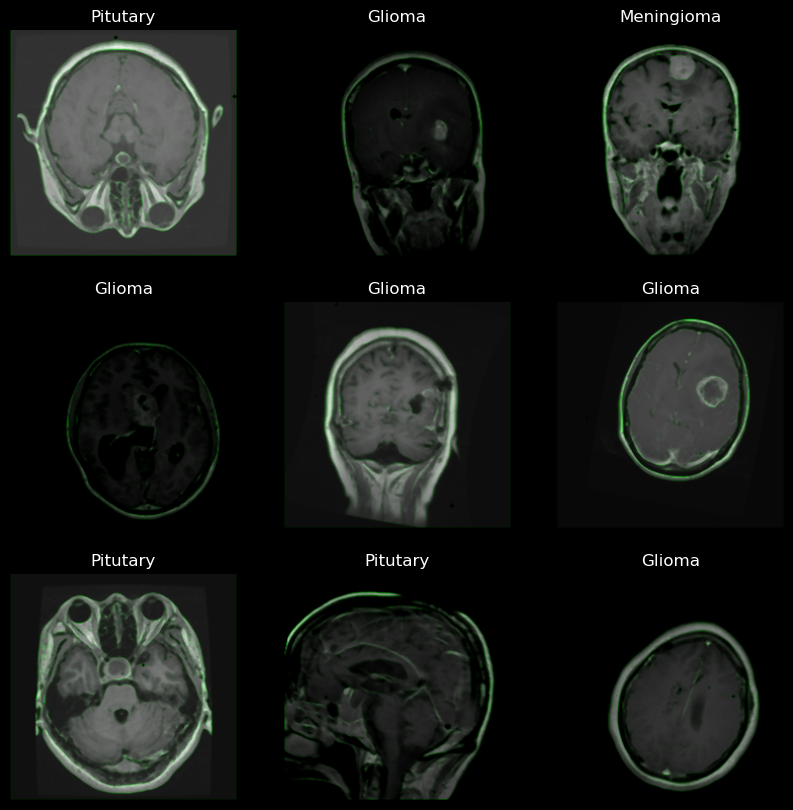

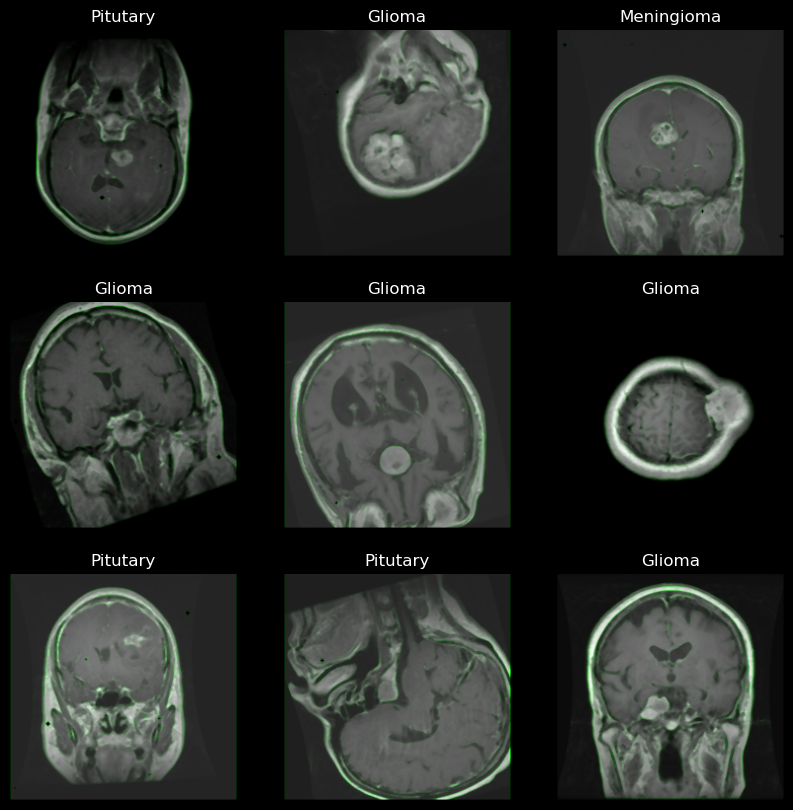

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_dataset[i][0])
    plt.title(classes[train_dataset[i][1] -1])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(val_dataset[i][0])
    plt.title(classes[train_dataset[i][1]-1])
    plt.axis("off")